In [1]:
import cf
import cfplot as cfp
import numpy as np

In [2]:
# change to your suite-id to pick up the required file
runid='cq988'
# time points and pseudo-levels to select
# 2nd time point (02:00:00)
tlev=cf.hour(cf.eq(2))
# 3rd pseudo-level, remembering that python starts counting at 0
pslev=2

In [3]:
# define the file locations
datafile='/home/vagrant/cylc-run/u-'+runid+'/work/1/atmos/atmosa.pa19810901_00'
orogfile='/home/vagrant/umdir/ancil/atmos/n48e/orography/globe30/v2/qrparm.orog'

In [4]:
# read-in the files
ukca=cf.read(datafile, select='stash_code=2530')[0].subspace(**{'id%UM_pseudolevel': [pslev]}, T=tlev).squeeze()
classic=cf.read(datafile, select='stash_code=2540')[0].subspace(**{'id%UM_pseudolevel': [pslev]}, T=tlev).squeeze()
orog=cf.read(orogfile, select='stash_code=33')[0]

In [5]:
# Include the orography field into the ukca field as a domain ancillary construct 
# that is contained by the appropriate coordinate reference construct
orog_axes = [orog.constructs.domain_axis_identity(axis) for axis in orog.get_data_axes()]
orog_da = cf.DomainAncillary(source=orog)
orog_key = ukca.set_construct(orog_da, axes=orog_axes)

cr = ukca.construct('standard_name:atmosphere_hybrid_height_coordinate')
cr.coordinate_conversion.set_domain_ancillary('orog', orog_key)

# Now the one-liner!
ukca.compute_vertical_coordinates(inplace=True)

In [6]:
bounds=ukca.coord('altitude').bounds.array[:,:,:,1] - ukca.coord('altitude').bounds.array[:,:,:,0]

In [7]:
ukca.data=ukca.data*bounds
classic.data=classic.data*bounds

In [8]:
ukca_int=ukca.collapse('Z: sum').squeeze()
classic_int=classic.collapse('Z: sum').squeeze()

In [9]:
aod=ukca_int.copy()
aod.nc_set_variable('od550aer')
aod.set_property('standard_name','atmosphere_optical_thickness_due_to_aerosol')
aod.set_property('long_name','atmosphere optical thickness due to aerosol')
# initialise the field to zero prior to the sum
aod.data=np.zeros(aod.data.shape)

In [10]:
aod.data = ukca_int.data + classic_int.data

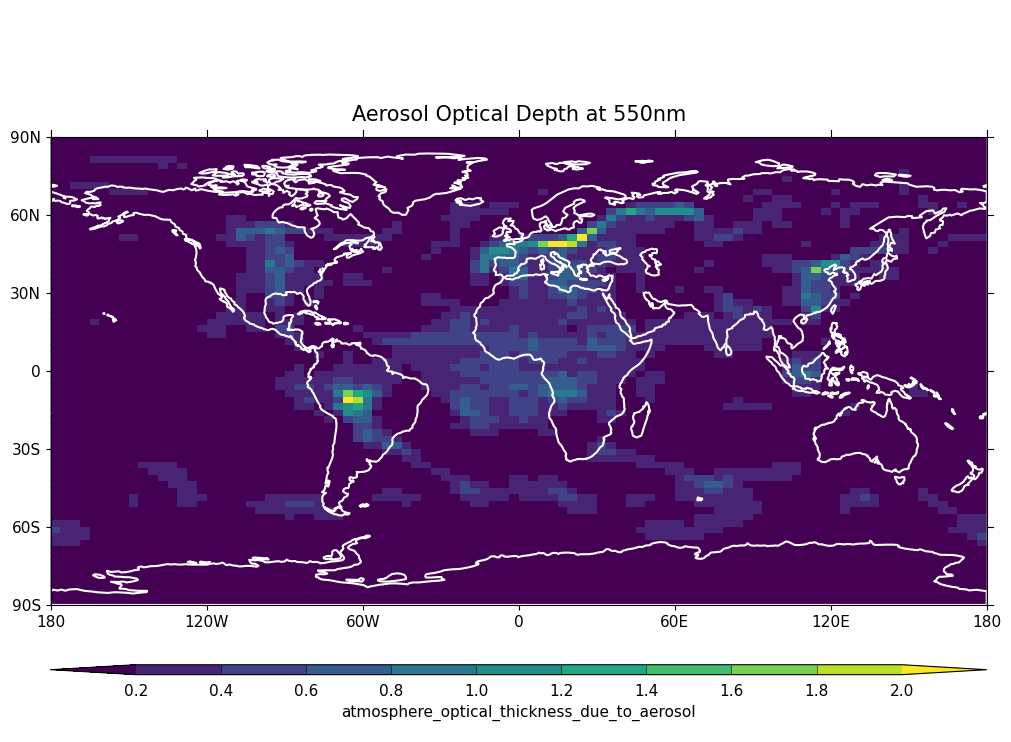

In [11]:
# plot the AOD
# change the colours of the continents to make the clearer to see
cfp.setvars(continent_color='w')
cfp.con(aod, blockfill_fast=True, lines=False, title='Aerosol Optical Depth at 550nm')

In [12]:
# save the AOD field in NetCDF format
cf.write(aod, '/home/vagrant/Task125_AOD.nc', fmt='NETCDF4')

In [13]:
# now read-in the Task 12.2 field and calculate the difference from this
aod_T122=cf.read('/home/vagrant/Task122_AOD.nc', select='atmosphere_optical_thickness_due_to_aerosol')[0]

In [14]:
diff=aod-aod_T122

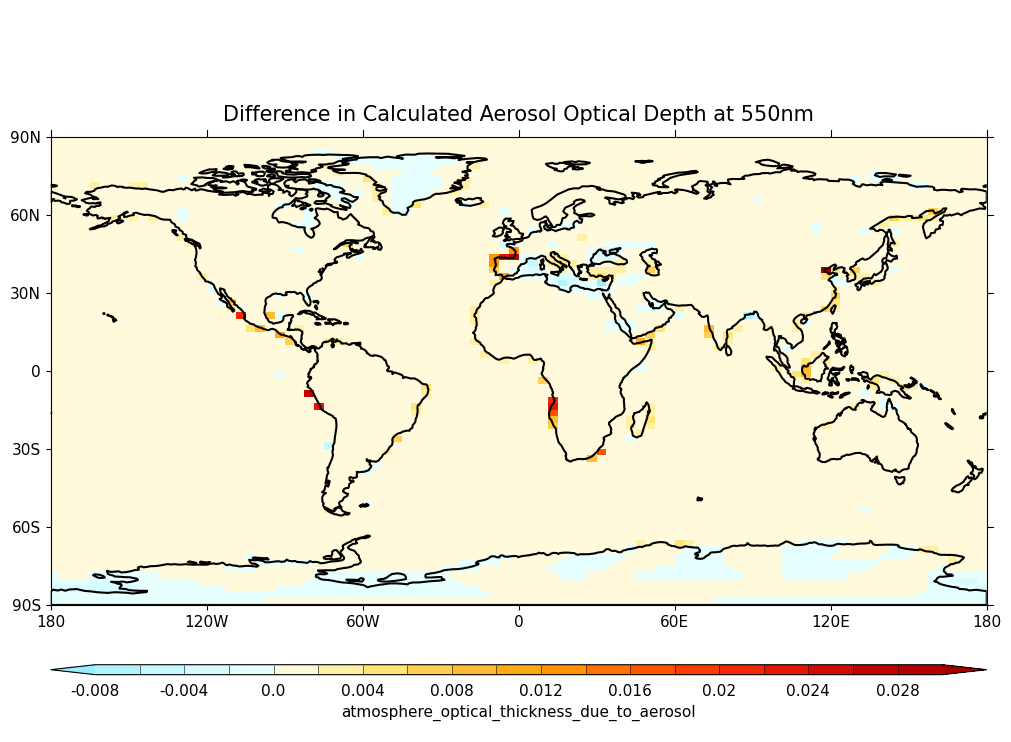

In [15]:
# plot the AOD
# change the colours of the continents to make the clearer to see
cfp.setvars(continent_color='k')
cfp.con(diff, blockfill_fast=True, lines=False, title='Difference in Calculated Aerosol Optical Depth at 550nm')

In [16]:
# see what the largest difference is - hopefully zero!
print(diff.max())

0.030244191688821975


In [17]:
# save the AOD field in NetCDF format
cf.write(diff, '/home/vagrant/Task125_AOD_diff.nc', fmt='NETCDF4')